In [28]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../beit2')
from datamodules import DATAMODULE_REGISTRY
from models import MODEL_REGISTRY
import torch
from pytorch_lightning import LightningModule
import torch.nn as nn
import pytorch_lightning as pl
from data.imagenet_zeroshot_data import imagenet_classnames
import timm
import matplotlib.pyplot as plt
plt.rcParams["axes.axisbelow"] = False
import numpy as np
from transformers import BertTokenizer
import textwrap

In [31]:
def fit_text(figure, axes, text):
    bbox = axes.get_position()
    fig_width_inch = figure.get_size_inches()[0]
    axes_width_inch = bbox.width * fig_width_inch
    char_width_inch = 0.1
    max_chars_per_line = int(axes_width_inch / char_width_inch)
    wrapped_text = "\n".join(textwrap.wrap(text, width=max_chars_per_line))
    return wrapped_text

In [51]:
def plot_prob_distribution(image, caption, top_probs, top_classes): 
    fig = plt.figure(figsize=(8, 4))

    gs = fig.add_gridspec(1, 2, wspace=0, hspace=0.3)

    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(image.permute(1, 2, 0))
    ax.axis("off")
    wrapped_caption = fit_text(figure=fig, axes=ax, text=caption)
    ax.set_title(label=wrapped_caption, fontsize=10)

    ax = fig.add_subplot(gs[0, 1])
    ax.barh(np.arange(5), top_probs)
    ax.set_xlim(0, 1.1)
    ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
    # ax.invert_yaxis()
    # ax.set_axisbelow(True)
    ax.tick_params(axis='y', direction='in', pad=-10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left') 
    ax.set_yticks(np.arange(top_probs.shape[-1]), top_classes)

    plt.show()

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
coco_dm_kwargs = {
    'data_path': '/workspace',
    'num_max_bpe_tokens': 64,
    'color_jitter': None,
    'beit_transforms': False,
    'crop_scale': [1.0, 1.0],
    'batch_size': 5,
    'num_workers': 1,
    'shuffle': True,
    'drop_last': False,
}

In [14]:
pl.seed_everything(42)
coco_dm = DATAMODULE_REGISTRY['coco_captions'](**coco_dm_kwargs)

Seed set to 42


In [16]:
coco_dm.prepare_data()
coco_dm.setup('fit')

2024-09-04 22:17:51 | INFO | datasets_.base_datasets | [COCOCaptions]: Load 566747 image-text pairs from /workspace/coco/coco_captioning.train.jsonl. 
2024-09-04 22:17:51 | INFO | datasets_.base_datasets | [COCOCaptions]: Load 25010 image-text pairs from /workspace/coco/coco_captioning.val.jsonl. 


In [17]:
dl = iter(coco_dm.train_dataloader())

In [18]:
model = timm.create_model('resnet50.a1_in1k', pretrained=True)
model.requires_grad_(False)
model.eval()

2024-09-04 22:17:51 | INFO | timm.models._builder | Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
2024-09-04 22:17:52 | INFO | timm.models._hub | [timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [40]:
batch = next(dl)
with torch.no_grad():
    img_out = model(batch['image_teacher']).softmax(dim=-1)
img_probs, img_labels = img_out.cpu().topk(5, dim=-1)
img_top_classes = []
for topk_indices in img_labels:
    top_classes_for_sample = [imagenet_classnames[idx] for idx in topk_indices]
    img_top_classes.append(top_classes_for_sample)

In [42]:
raw_text = tokenizer.batch_decode(batch['text'], skip_special_tokens=True)

2024-09-04 22:35:23 | WARNING | matplotlib.image | Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
/tmp/ipykernel_10106/10373266.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')


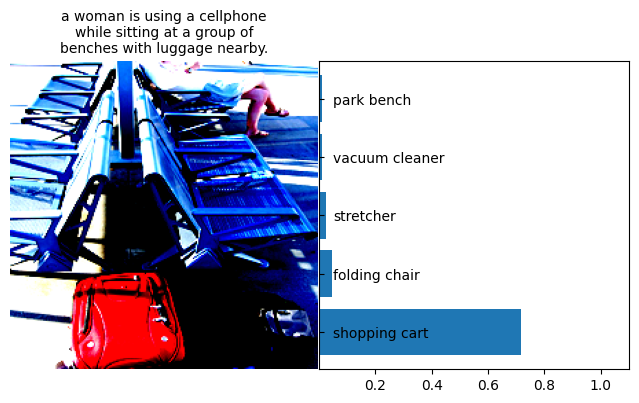

2024-09-04 22:35:23 | WARNING | matplotlib.image | Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
/tmp/ipykernel_10106/10373266.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')


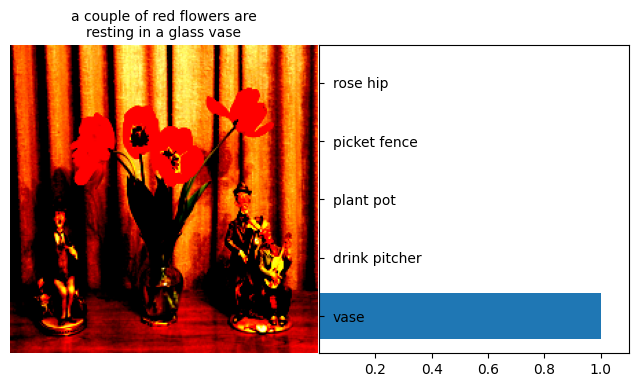

2024-09-04 22:35:23 | WARNING | matplotlib.image | Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..1.9602618].
/tmp/ipykernel_10106/10373266.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')


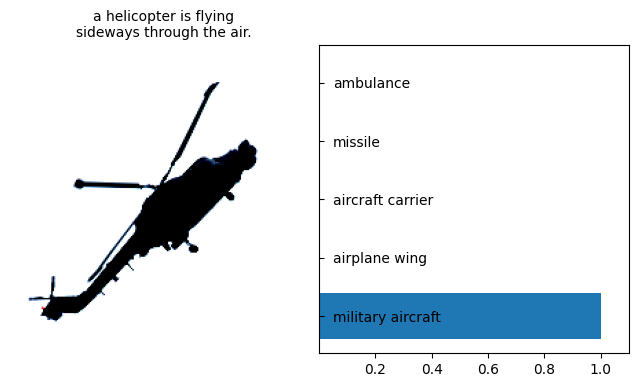

2024-09-04 22:35:23 | WARNING | matplotlib.image | Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].
/tmp/ipykernel_10106/10373266.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')


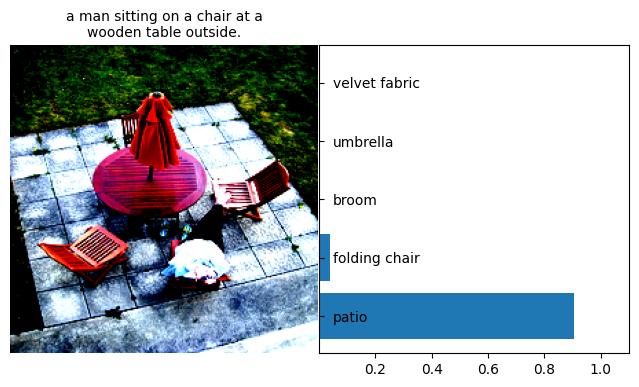

2024-09-04 22:35:23 | WARNING | matplotlib.image | Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.7511115].
/tmp/ipykernel_10106/10373266.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')


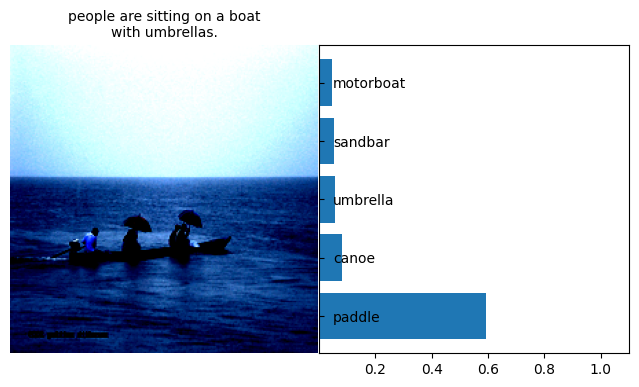

In [52]:
for i in range(img_out.shape[0]):
    plot_prob_distribution(batch['image'][i], raw_text[i], img_probs[i], img_top_classes[i])